# Variational Autoencoders for galaxy images

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import MNIST

import torch.nn.functional as F


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convert Galaxy10 dataset into Pytorch format

See more information about the data set here: https://astronn.readthedocs.io/en/latest/galaxy10.html

In [ ]:
!wget http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

--2024-10-23 17:59:14--  http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Resolving astro.utoronto.ca (astro.utoronto.ca)... 142.1.217.162
Connecting to astro.utoronto.ca (astro.utoronto.ca)|142.1.217.162|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5 [following]
--2024-10-23 17:59:15--  https://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Connecting to astro.utoronto.ca (astro.utoronto.ca)|142.1.217.162|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5 [following]
--2024-10-23 17:59:16--  https://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Resolving www.astro.utoronto.ca (www.astro.utoronto.ca)... 128.100.89.92
Connecting to www.astro.utoronto.ca (www.astro.utoronto.ca)|128.100.89.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210234548 (200M)
Saving to: ‘G

In [ ]:
# load entire file into memory
with h5py.File('Galaxy10.h5', 'r') as f:
    print(list(f.keys()))
    images = np.array(f['images'])
    labels = np.array(f['ans'])

images.shape

['ans', 'images']


(21785, 69, 69, 3)

In [ ]:
# pre-process
images = (images / 255.).astype(np.float32)

In [ ]:
class GalaxyDataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
# random split
N = len(images)

np.random.seed(12345)
indices = np.random.permutation(N)
train_idxs = indices[:int(0.8*N)]
valid_idxs = indices[int(0.8*N):]

In [ ]:
# transforms and train/valid split
transform = transforms.ToTensor()

train_ds = GalaxyDataset(images[train_idxs], labels[train_idxs], transform)
valid_ds = GalaxyDataset(images[valid_idxs], labels[valid_idxs], transform)

In [ ]:
train_loader = DataLoader(
    train_ds,
    batch_size=128,
    num_workers=1,
    shuffle=True,
    pin_memory=torch.cuda.is_available()
)

valid_loader = DataLoader(
    valid_ds,
    batch_size=128,
    num_workers=1,
    shuffle=True,
    pin_memory=torch.cuda.is_available()
)

# VAEs

Some of this is based on vanilla VAEs here: https://github.com/Atcold/pytorch-Deep-Learning/blob/master/11-VAE.ipynb

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, d):
        super().__init__()

        self.d = d

        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, 2, padding=1),    # 35x35
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 2, padding=1),   # 18x18
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.enc3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*18*18, 2*d)
        )

        self.dec1 = nn.Sequential(
            nn.Linear(d, 32*18*18),
            nn.Unflatten(1, (32, 18, 18)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 1, padding=1, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(16, 3, 3, 1, padding=1, output_padding=0),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        if self.training:
            return mu + torch.randn(mu.shape).to(device)*torch.exp(0.5*logvar)
        else:
            return mu

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        mu_logvar = self.enc3(x).view(-1, 2, self.d)

        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]

        z = self.reparameterize(mu, logvar)

        x_hat = self.dec1(z)
        x_hat = F.interpolate(x_hat, size=(35, 35), mode='bilinear')

        x_hat = self.dec2(x_hat)
        x_hat = F.interpolate(x_hat, size=(69, 69), mode='bilinear')
        return self.dec3(x_hat), mu, logvar

## Helper functions

In [ ]:
def display_images(in_, out, nrows=1, ncols=4, label=None, count=False):
    for row in range(nrows):
        if in_ is not None:
            in_pic = np.array(in_.data.cpu() * 255, dtype=int).transpose((0, 2, 3, 1))
            plt.figure(figsize=(18, 4))
            plt.suptitle(label, color='w', fontsize=16)
            for col in range(ncols):
                plt.subplot(1, ncols, col + 1)
                plt.imshow(in_pic[col + ncols * row])
                plt.axis('off')
        out_pic = np.array(out.data.cpu() * 255, dtype=int).transpose((0, 2, 3, 1))
        plt.figure(figsize=(18, 6))
        for col in range(ncols):
            plt.subplot(1, ncols, col + 1)
            plt.imshow(out_pic[col + ncols * row])
            plt.axis('off')
            if count: plt.title(str(col + ncols * row), color='w')


## ELBO as a VAE loss function

In [ ]:
model = ConvVAE(d=20).to(device)

In [ ]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

def ELBO(x_hat, x, mu, logvar):
    MSE = torch.nn.MSELoss(reduction='sum')(x_hat, x)

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

 Epoch 0 | Train: 574.8 | Valid: 64.6


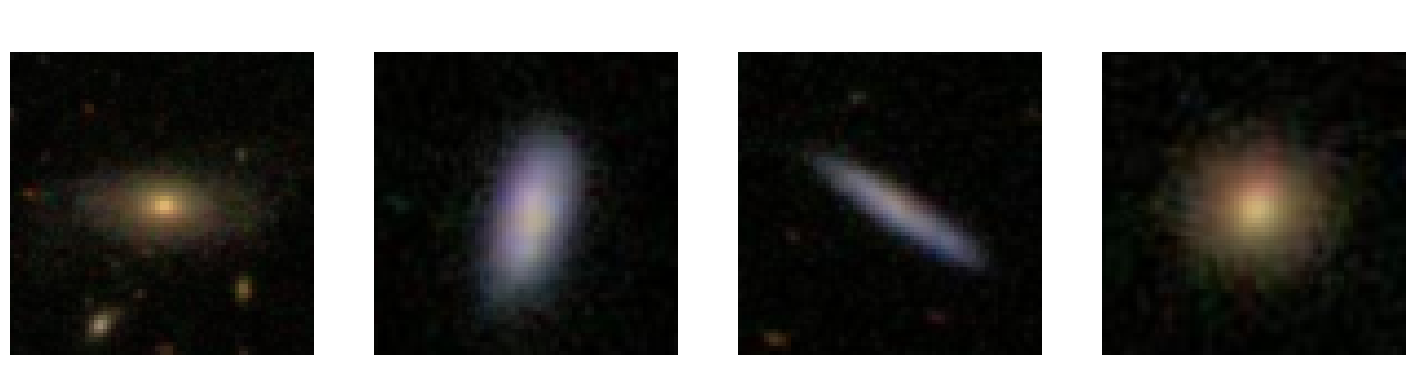

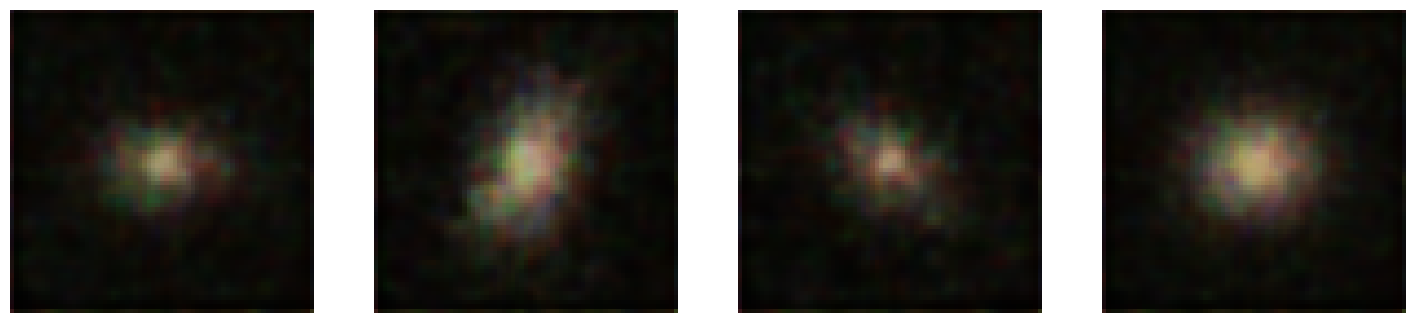

 Epoch 1 | Train: 64.6 | Valid: 55.0
 Epoch 2 | Train: 56.3 | Valid: 48.8
 Epoch 3 | Train: 51.2 | Valid: 44.0
 Epoch 4 | Train: 47.3 | Valid: 41.4
 Epoch 5 | Train: 45.8 | Valid: 49.3
 Epoch 6 | Train: 44.4 | Valid: 39.2
 Epoch 7 | Train: 42.4 | Valid: 45.3
 Epoch 8 | Train: 43.5 | Valid: 46.5
 Epoch 9 | Train: 41.5 | Valid: 38.3
 Epoch 10 | Train: 39.5 | Valid: 36.1


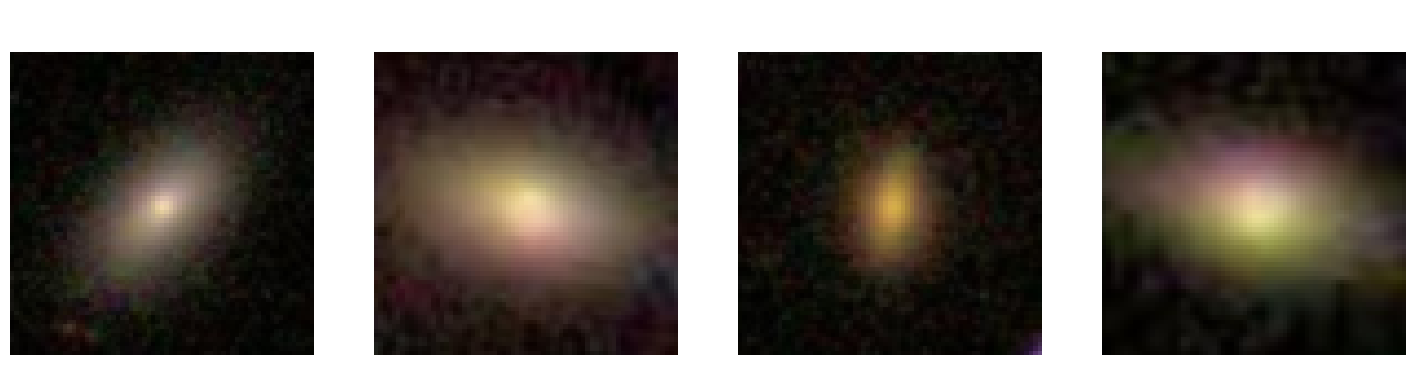

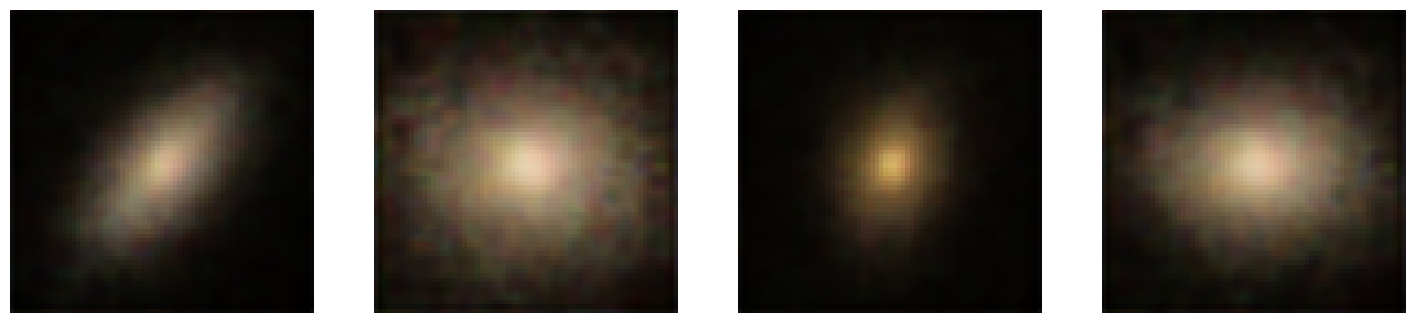

 Epoch 11 | Train: 37.7 | Valid: 39.5
 Epoch 12 | Train: 36.9 | Valid: 35.5
 Epoch 13 | Train: 35.8 | Valid: 36.2
 Epoch 14 | Train: 39.3 | Valid: 35.8
 Epoch 15 | Train: 36.2 | Valid: 31.5
 Epoch 16 | Train: 34.9 | Valid: 33.2
 Epoch 17 | Train: 34.0 | Valid: 30.7
 Epoch 18 | Train: 33.7 | Valid: 29.4
 Epoch 19 | Train: 33.6 | Valid: 30.9
 Epoch 20 | Train: 32.9 | Valid: 32.6


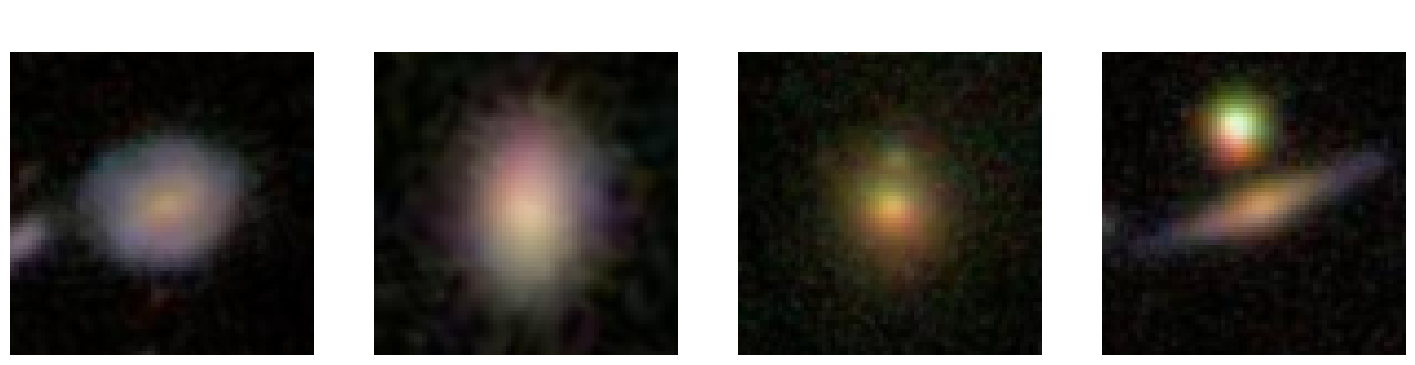

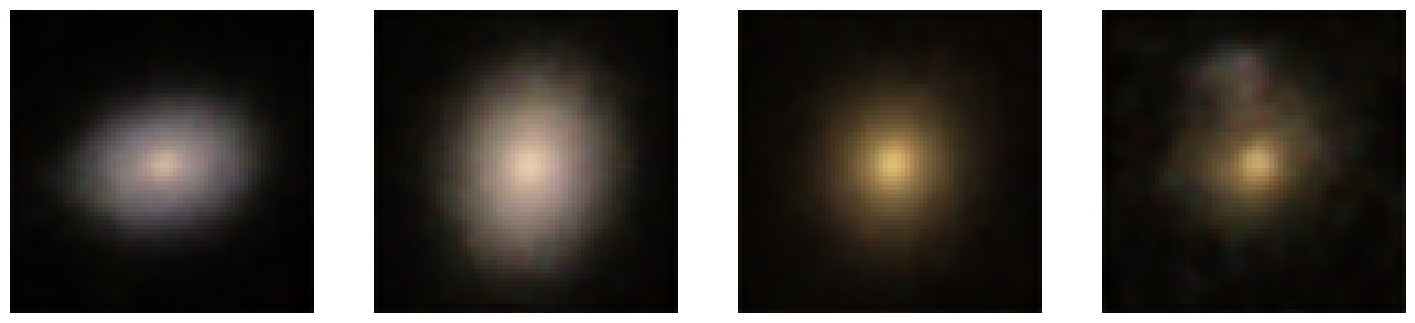

 Epoch 21 | Train: 32.8 | Valid: 31.5
 Epoch 22 | Train: 32.5 | Valid: 28.2
 Epoch 23 | Train: 32.3 | Valid: 30.6
 Epoch 24 | Train: 33.2 | Valid: 28.8
 Epoch 25 | Train: 31.5 | Valid: 28.7
 Epoch 26 | Train: 31.7 | Valid: 29.8
 Epoch 27 | Train: 32.5 | Valid: 29.6
 Epoch 28 | Train: 31.2 | Valid: 28.4
 Epoch 29 | Train: 31.1 | Valid: 28.5
 Epoch 30 | Train: 30.9 | Valid: 28.0


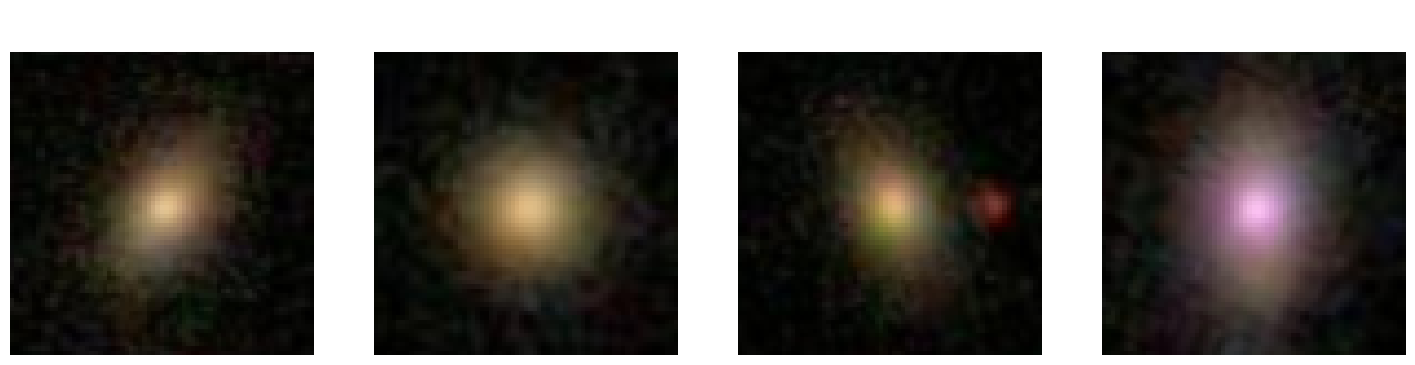

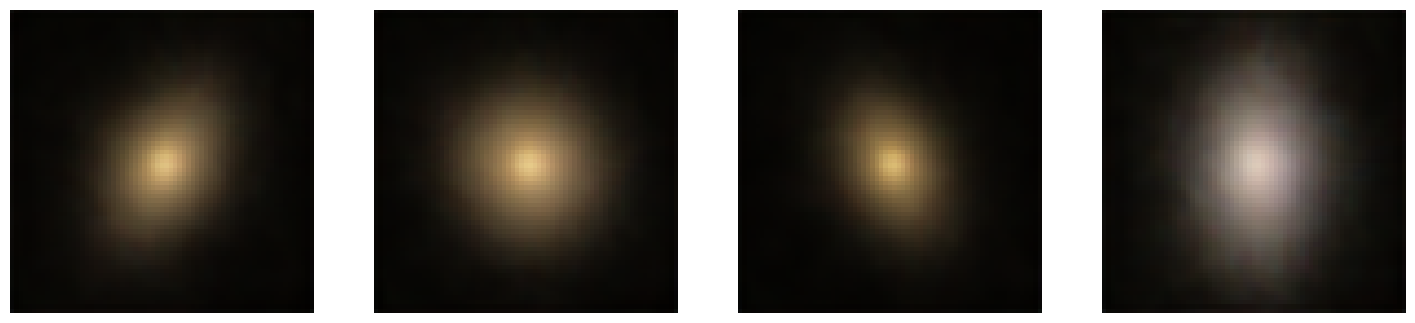

 Epoch 31 | Train: 30.5 | Valid: 35.2
 Epoch 32 | Train: 30.8 | Valid: 28.3
 Epoch 33 | Train: 30.3 | Valid: 26.8
 Epoch 34 | Train: 30.5 | Valid: 30.6
 Epoch 35 | Train: 30.3 | Valid: 32.2
 Epoch 36 | Train: 30.4 | Valid: 28.2
 Epoch 37 | Train: 30.0 | Valid: 29.1
 Epoch 38 | Train: 30.1 | Valid: 28.1
 Epoch 39 | Train: 29.7 | Valid: 28.2
 Epoch 40 | Train: 29.8 | Valid: 28.7


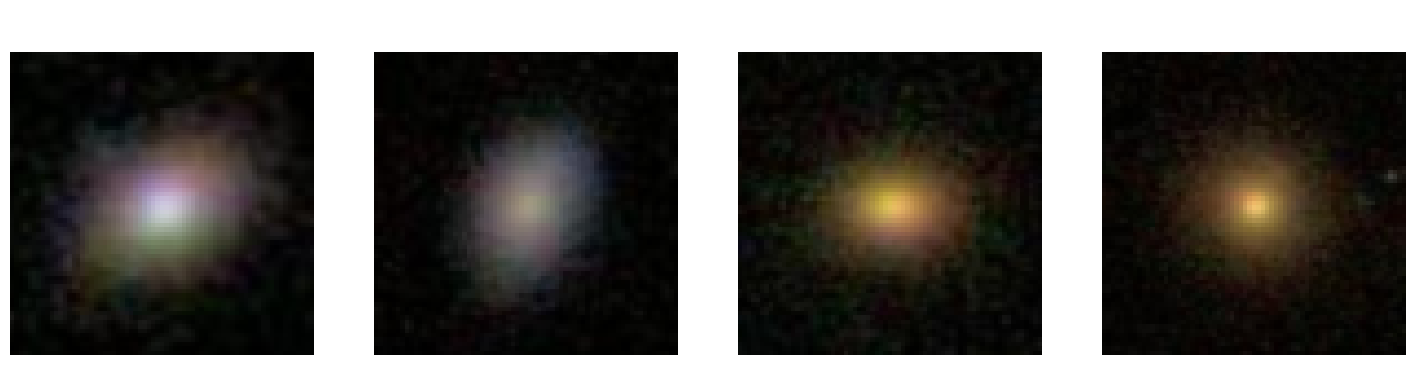

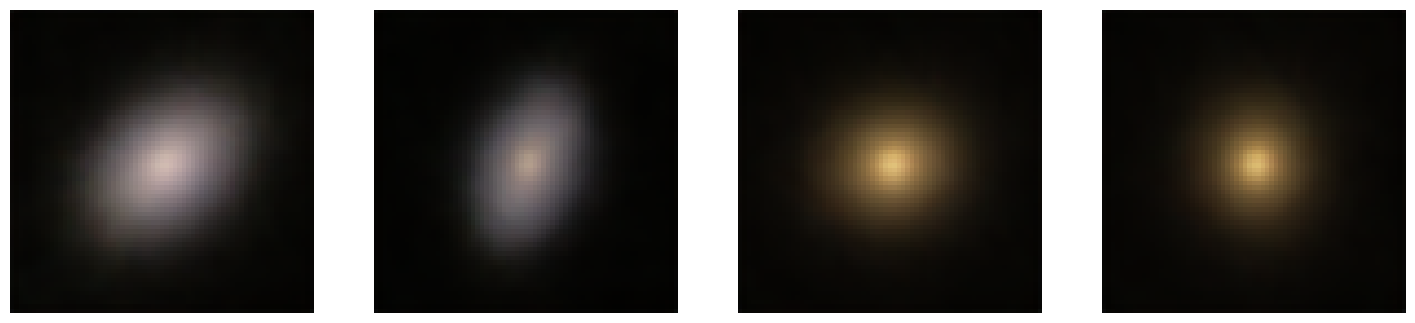

 Epoch 41 | Train: 29.9 | Valid: 27.7
 Epoch 42 | Train: 29.5 | Valid: 30.2
 Epoch 43 | Train: 29.7 | Valid: 27.4
 Epoch 44 | Train: 29.3 | Valid: 29.6
 Epoch 45 | Train: 29.3 | Valid: 26.4
 Epoch 46 | Train: 29.2 | Valid: 28.2
 Epoch 47 | Train: 29.1 | Valid: 27.6
 Epoch 48 | Train: 28.9 | Valid: 28.4
 Epoch 49 | Train: 29.0 | Valid: 29.4
 Epoch 50 | Train: 29.1 | Valid: 27.5


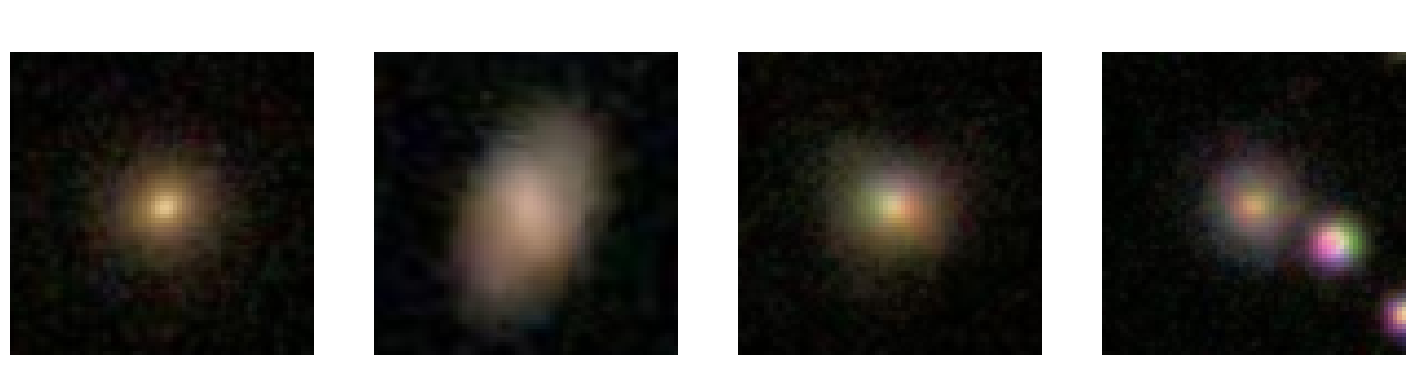

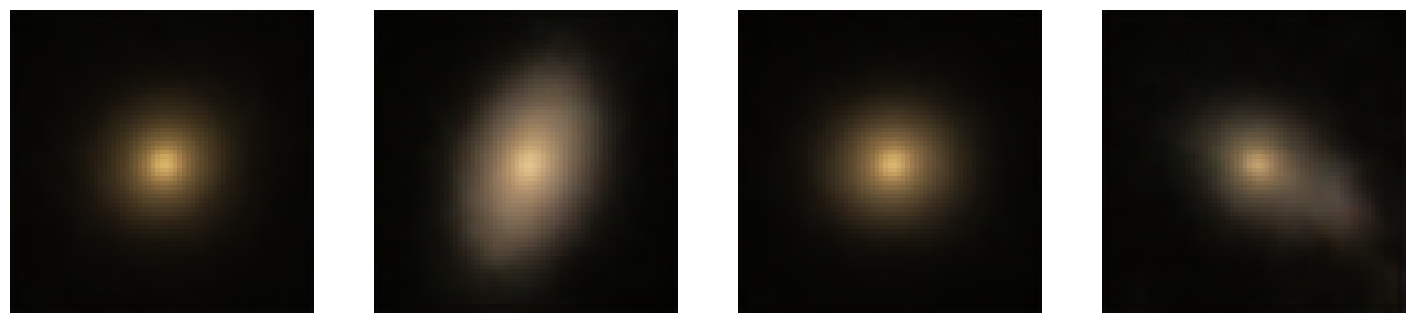

In [ ]:
validation_losses = []
for epoch in range(0, 51):
    # train
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x)
        loss = ELBO(x_hat, x, mu, logvar)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    # validate
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        for x, y in valid_loader:
            x = x.to(device)
            x_hat, mu, logvar = model(x)
            valid_loss += ELBO(x_hat, x, mu, logvar)

    validation_losses.append(valid_loss / len(valid_loader.dataset))
    print(f' Epoch {epoch} | Train: {train_loss / len(train_loader.dataset):.1f} | Valid: {validation_losses[-1]:.1f}')

    # display
    if epoch % 10 == 0:
        # The 'ncols' argument should be an integer, not a string.
        # Changed from: display_images(x, x_hat, 1, f'Epoch {epoch}')
        display_images(x, x_hat, 1, 4, label=f'Epoch {epoch}') # Pass 'Epoch {epoch}' as the label instead
        plt.show()

## MMD + ELBO loss function (InfoVAE)
See, e.g., https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/

In [ ]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1)
    y = y.unsqueeze(0)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    xx_kernel = compute_kernel(x,x)
    yy_kernel = compute_kernel(y,y)
    xy_kernel = compute_kernel(x,y)
    return torch.mean(xx_kernel) + torch.mean(yy_kernel) - 2*torch.mean(xy_kernel)

def MMD_loss(model, x_hat, x, mu, logvar, alpha=1.0, beta=1.0):

    MSE = torch.nn.MSELoss(reduction='sum')(x_hat, x)

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    true_samples = torch.autograd.Variable(
        torch.randn(200, model.d),
        requires_grad=False
    ).to(device)
    z = model.reparameterize(mu, logvar)
    MMD = compute_mmd(true_samples, z) * x.size(0) * model.d

    return MSE + (1 - alpha)*KLD + (beta + alpha-1)*MMD

In [ ]:
model_mmd = ConvVAE(d=50).to(device)

In [ ]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model_mmd.parameters(),
    lr=learning_rate,
)

 Epoch 0 | Train: 412.0 | Valid: 56.6


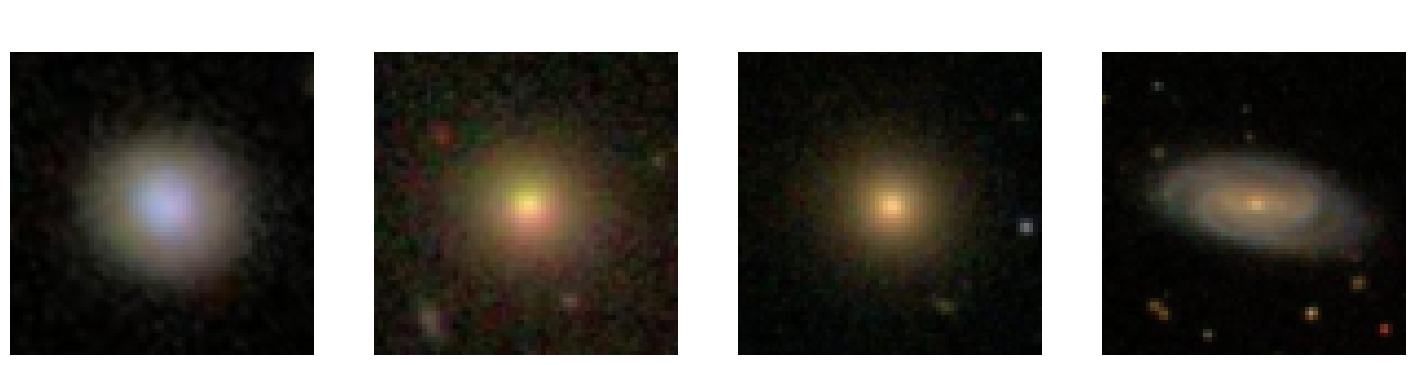

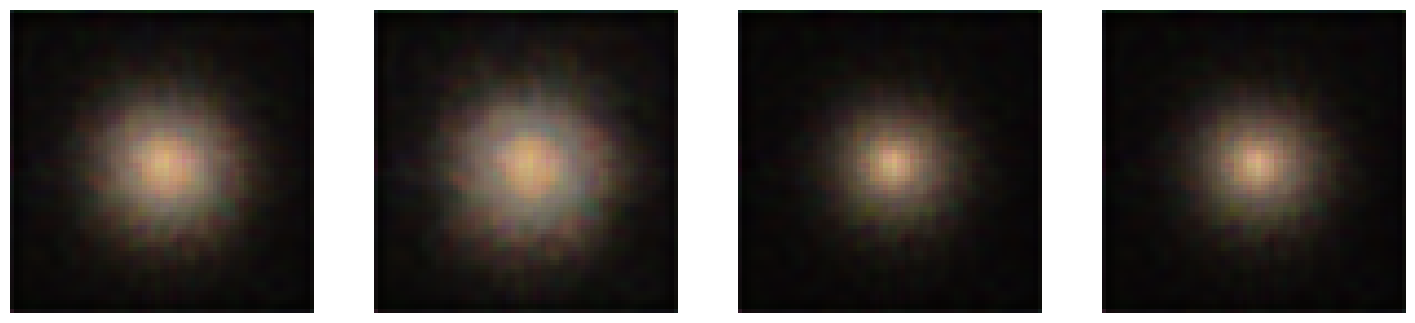

 Epoch 1 | Train: 45.6 | Valid: 39.7
 Epoch 2 | Train: 34.8 | Valid: 32.1
 Epoch 3 | Train: 30.1 | Valid: 27.6
 Epoch 4 | Train: 26.7 | Valid: 25.2
 Epoch 5 | Train: 24.5 | Valid: 24.9
 Epoch 6 | Train: 23.2 | Valid: 22.3
 Epoch 7 | Train: 21.9 | Valid: 21.9
 Epoch 8 | Train: 21.8 | Valid: 21.0
 Epoch 9 | Train: 20.7 | Valid: 20.2
 Epoch 10 | Train: 20.2 | Valid: 19.8


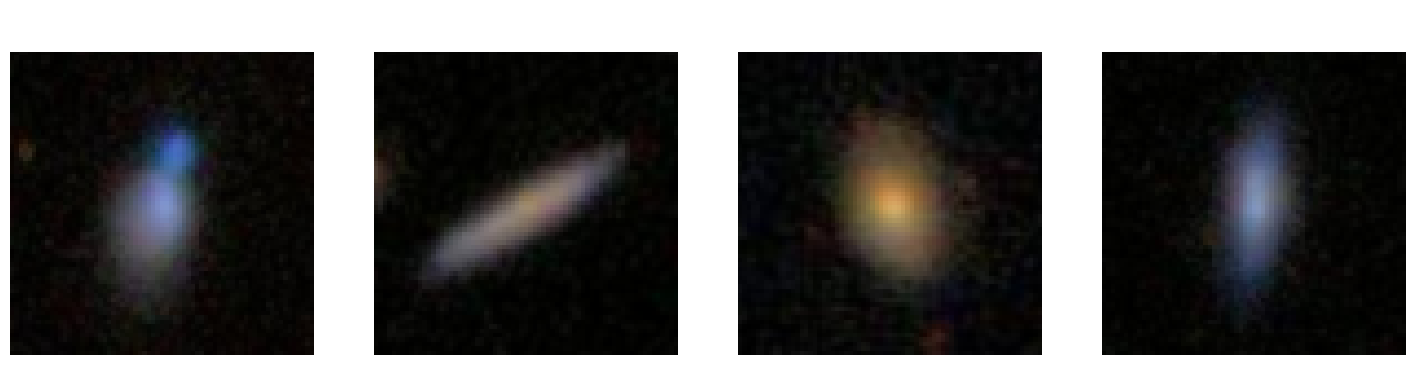

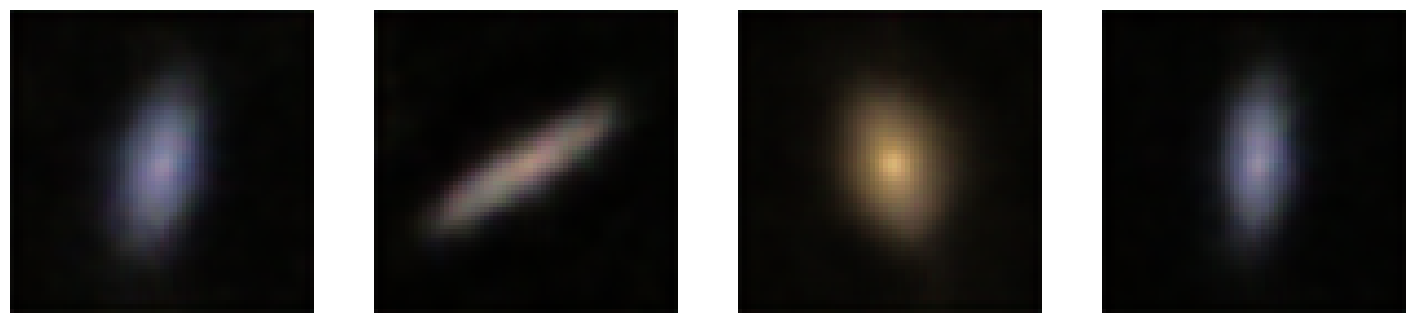

 Epoch 11 | Train: 19.8 | Valid: 21.0
 Epoch 12 | Train: 19.6 | Valid: 19.3
 Epoch 13 | Train: 19.3 | Valid: 19.5
 Epoch 14 | Train: 18.8 | Valid: 18.9
 Epoch 15 | Train: 18.7 | Valid: 19.9
 Epoch 16 | Train: 18.5 | Valid: 18.8
 Epoch 17 | Train: 18.4 | Valid: 18.9
 Epoch 18 | Train: 18.3 | Valid: 20.7
 Epoch 19 | Train: 18.2 | Valid: 18.3
 Epoch 20 | Train: 18.0 | Valid: 18.6


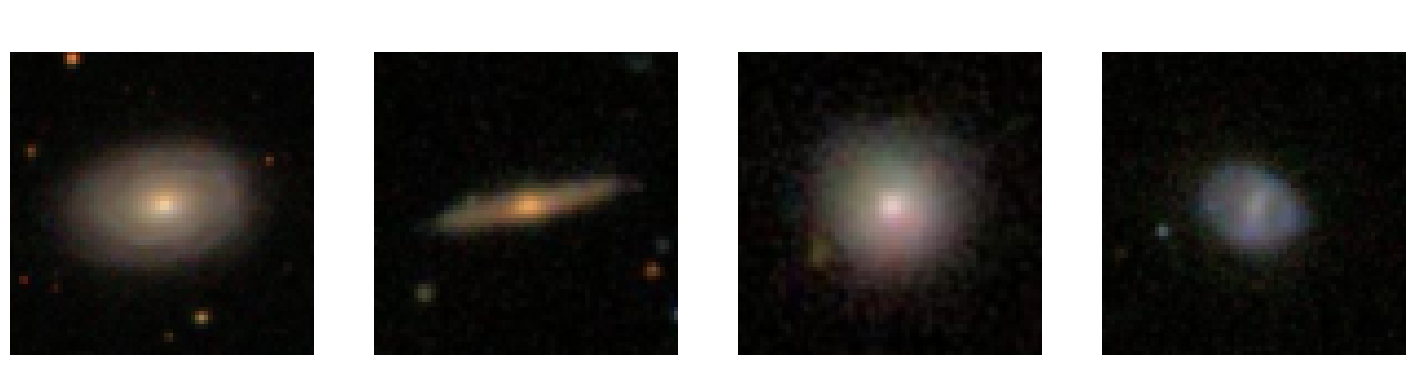

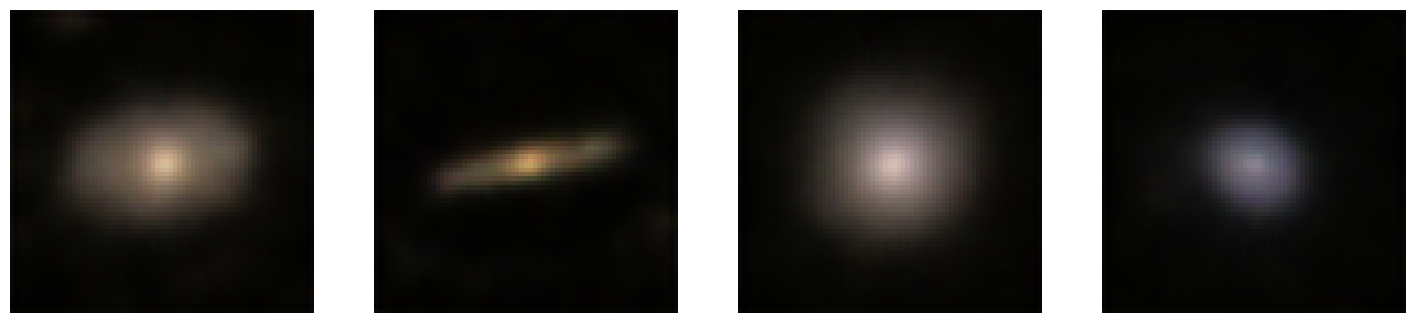

 Epoch 21 | Train: 17.9 | Valid: 18.3
 Epoch 22 | Train: 17.9 | Valid: 18.3
 Epoch 23 | Train: 17.8 | Valid: 18.5
 Epoch 24 | Train: 17.7 | Valid: 18.6
 Epoch 25 | Train: 17.5 | Valid: 18.3
 Epoch 26 | Train: 17.4 | Valid: 18.3
 Epoch 27 | Train: 17.4 | Valid: 18.1
 Epoch 28 | Train: 17.2 | Valid: 17.8
 Epoch 29 | Train: 17.1 | Valid: 18.2
 Epoch 30 | Train: 17.1 | Valid: 17.9


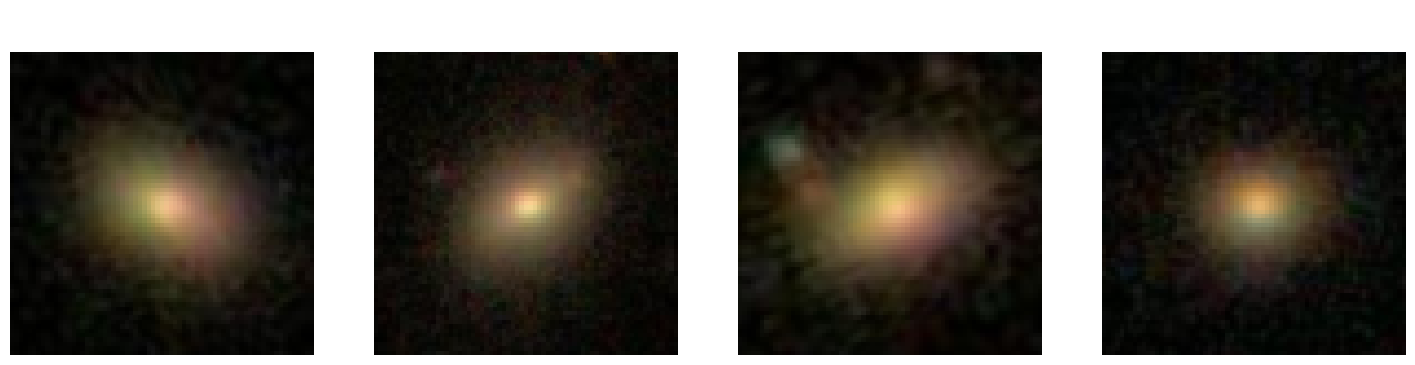

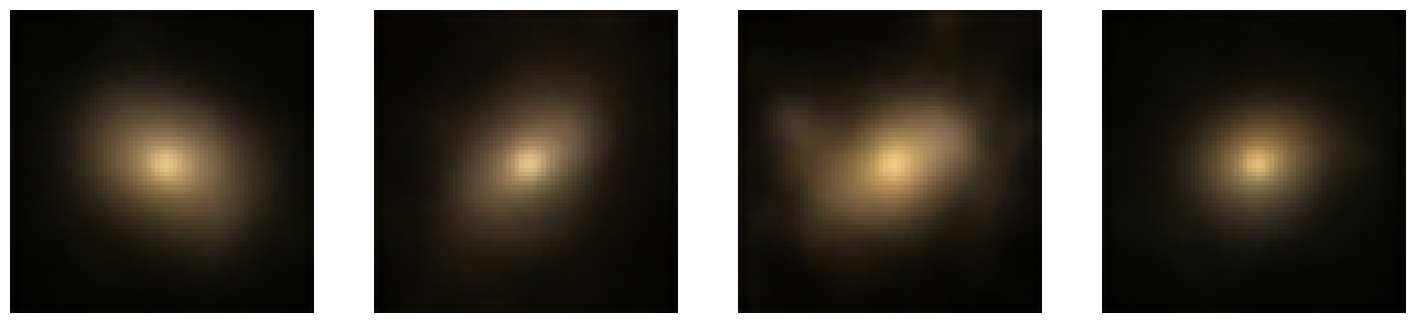

 Epoch 31 | Train: 17.1 | Valid: 17.7
 Epoch 32 | Train: 17.0 | Valid: 17.5
 Epoch 33 | Train: 16.8 | Valid: 17.4
 Epoch 34 | Train: 16.8 | Valid: 18.0
 Epoch 35 | Train: 16.7 | Valid: 17.5
 Epoch 36 | Train: 16.7 | Valid: 17.7
 Epoch 37 | Train: 16.7 | Valid: 18.0
 Epoch 38 | Train: 16.7 | Valid: 17.4
 Epoch 39 | Train: 16.6 | Valid: 17.3
 Epoch 40 | Train: 16.5 | Valid: 18.0


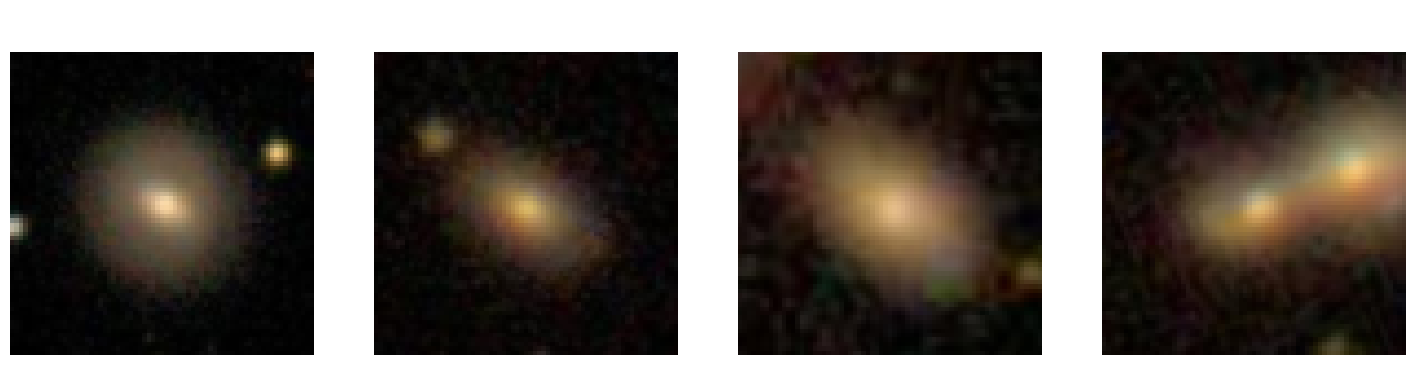

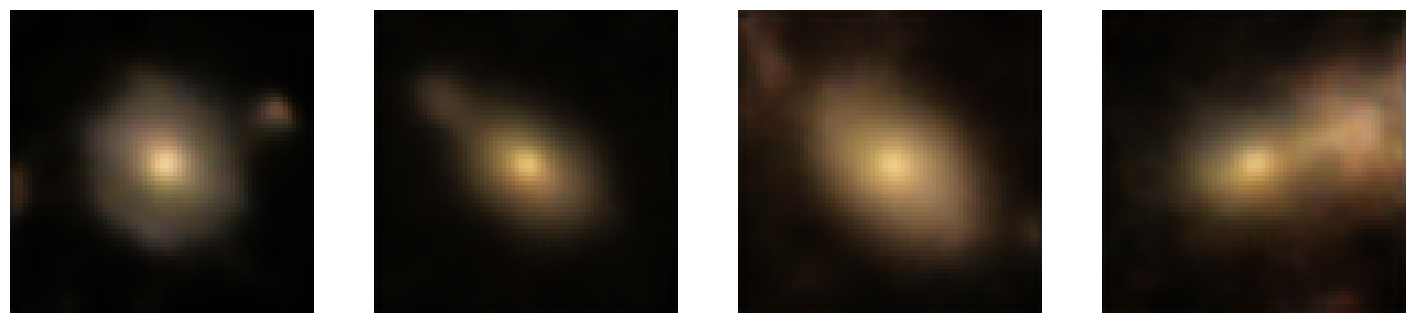

 Epoch 41 | Train: 16.5 | Valid: 17.6
 Epoch 42 | Train: 16.8 | Valid: 17.5
 Epoch 43 | Train: 16.4 | Valid: 17.4
 Epoch 44 | Train: 16.5 | Valid: 17.3
 Epoch 45 | Train: 16.2 | Valid: 17.4
 Epoch 46 | Train: 16.2 | Valid: 17.2
 Epoch 47 | Train: 16.1 | Valid: 17.6
 Epoch 48 | Train: 16.2 | Valid: 17.3
 Epoch 49 | Train: 16.1 | Valid: 17.2
 Epoch 50 | Train: 16.1 | Valid: 17.2


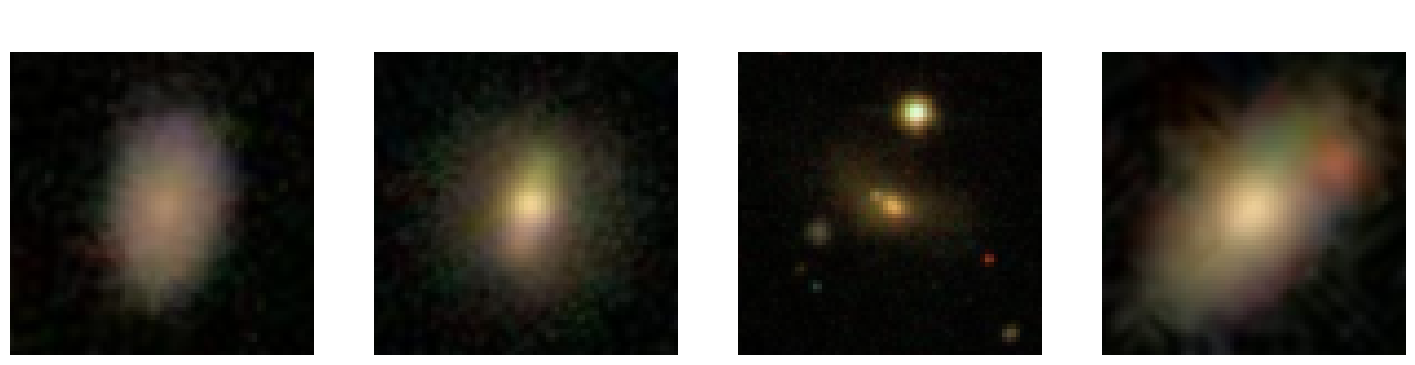

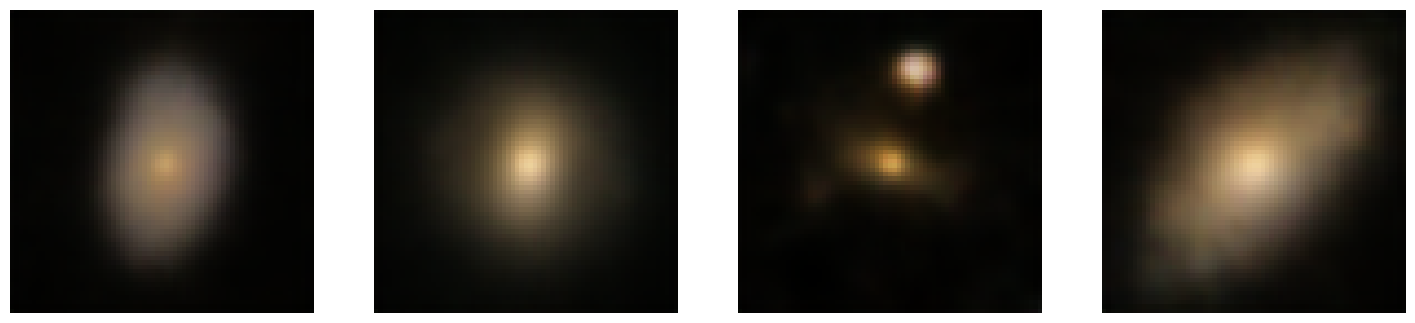

In [ ]:
MMD_validation_losses = []

for epoch in range(0, 51):
    # train
    model_mmd.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        x_hat, mu, logvar = model_mmd(x)
        loss = MMD_loss(model_mmd, x_hat, x, mu, logvar)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # validate
    with torch.no_grad():
        model_mmd.eval()
        valid_loss = 0
        for x, y in valid_loader:
            x = x.to(device)
            x_hat, mu, logvar = model_mmd(x)
            valid_loss += MMD_loss(model_mmd, x_hat, x, mu, logvar)

    MMD_validation_losses.append(valid_loss / len(valid_loader.dataset))
    print(f' Epoch {epoch} | Train: {train_loss / len(train_loader.dataset):.1f} | Valid: {MMD_validation_losses[-1]:.1f}')

    # display
    if epoch % 10 == 0:
        # The 'ncols' argument should be an integer, not a string.
        # Changed from: display_images(x, x_hat, 1, f'Epoch {epoch}')
        display_images(x, x_hat, 1, 4, label=f'Epoch {epoch}') # Pass 'Epoch {epoch}' as the label instead
        plt.show()

# Training dynamics

(15.0, 50.0)

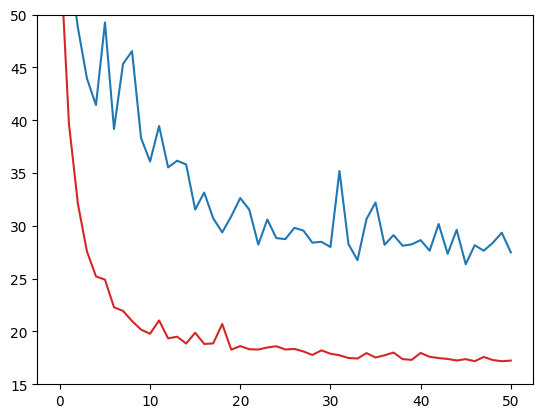

In [ ]:
import matplotlib.pyplot as plt
# obviously these two can't be compared but we can see that they've started to converge....?
# Move tensors to CPU and detach from computation graph
validation_losses_cpu = [loss.cpu().detach().numpy() for loss in validation_losses]
MMD_validation_losses_cpu = [loss.cpu().detach().numpy() for loss in MMD_validation_losses]

plt.plot(validation_losses_cpu, c='C0')
plt.plot(MMD_validation_losses_cpu, c='C3')

plt.ylim(15, 50)

# Display latent space representations

In [ ]:
valid_idxs.shape

(4357,)

## ELBO

In [ ]:
mu_list = []
y_list = []
with torch.no_grad():
    model.eval()

    for x, y in valid_loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x)

        mu_list.append(mu)
        y_list.append(y)

mu_list = torch.cat(mu_list).cpu()
y_list = torch.cat(y_list).cpu()

In [ ]:
# PCA reduce latent variables

pca = PCA(n_components=10)
mu_pca_list = pca.fit_transform(mu_list)
pca.explained_variance_ratio_

array([0.17426758, 0.13793141, 0.12907236, 0.10058476, 0.06906609,
       0.05640842, 0.05081488, 0.03186819, 0.03006725, 0.02796776])

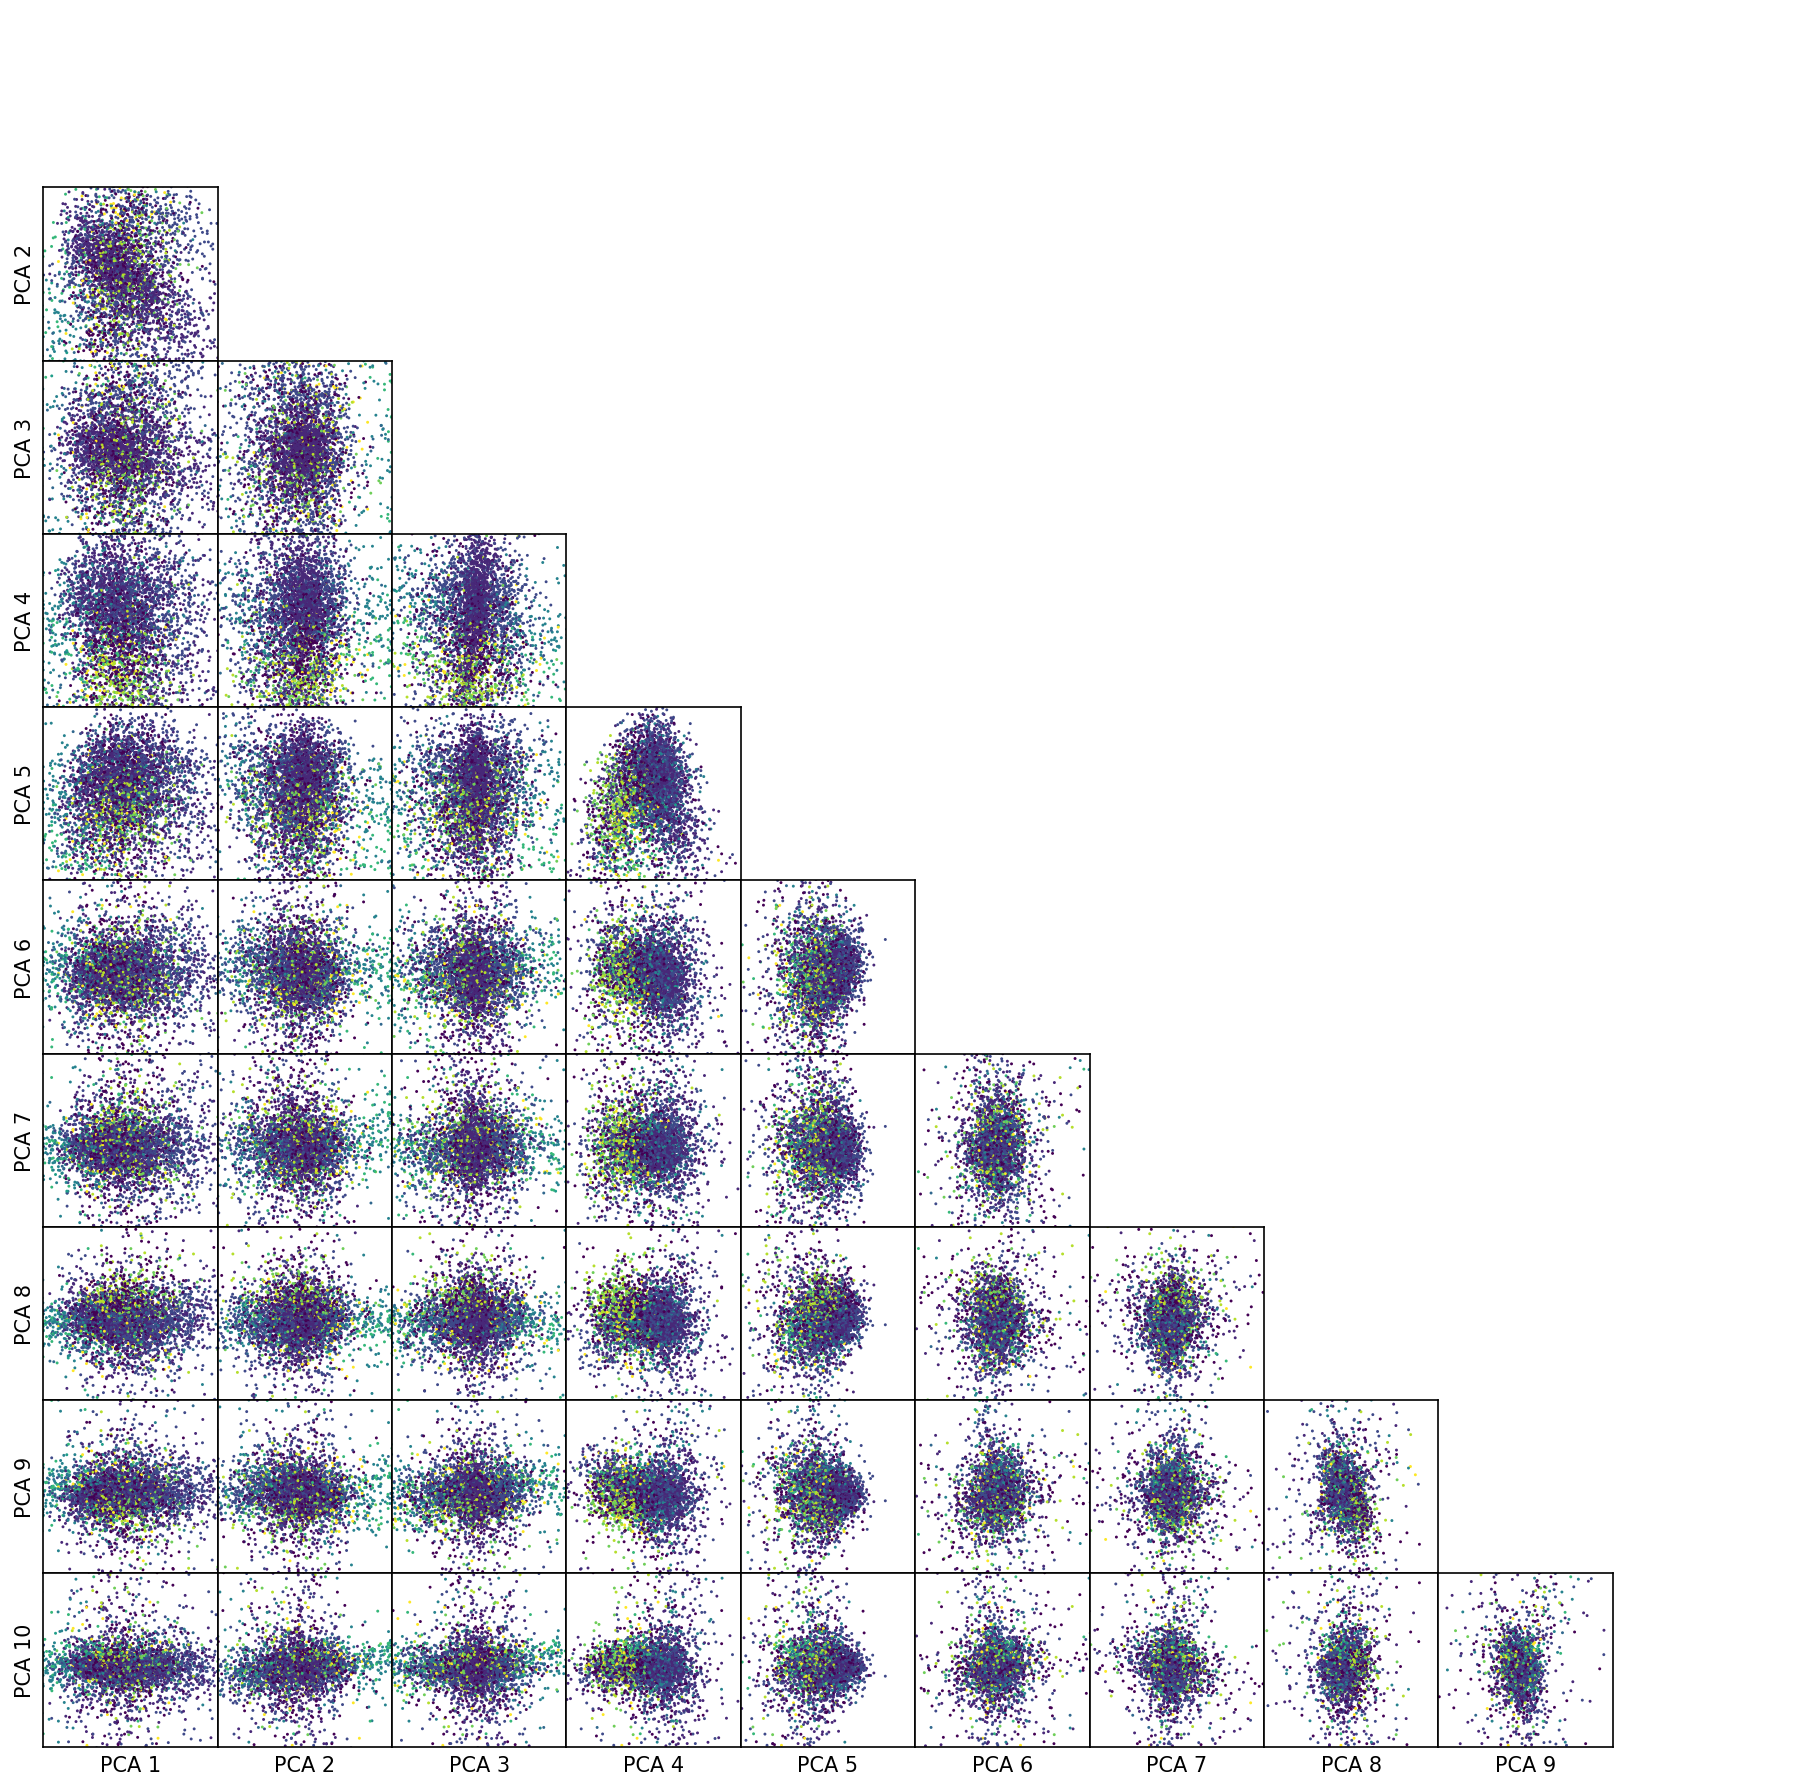

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15), sharex=True, sharey=True, dpi=150)

for i, ax_col in enumerate(axes):
    for j, ax in enumerate(ax_col):
        if j >= i:
            ax.axis('off')
            continue

        ax.scatter(mu_pca_list[:, j], mu_pca_list[:, i], c=y_list, s=2, edgecolor='none')

        if i == 9:
            ax.set_xlabel(f'PCA {j+1}')
            ax.set_ylim(*np.quantile(mu_pca_list[:, i], [0.01, 0.99]))
        if j == 0:
            ax.set_ylabel(f'PCA {i+1}')
            ax.set_xlim(*np.quantile(mu_pca_list[:, j], [0.01, 0.99]))
        ax.set_xticks([])
        ax.set_yticks([])

fig.subplots_adjust(wspace=0, hspace=0)

## MMD

In [45]:
mu_list = []
y_list = []
with torch.no_grad():
    model_mmd.eval()

    for x, y in valid_loader:
        x = x.to(device)
        x_hat, mu, logvar = model_mmd(x)

        mu_list.append(mu)
        y_list.append(y)

mu_list = torch.cat(mu_list).cpu()
y_list = torch.cat(y_list).cpu()

In [46]:
pca = PCA(n_components=10)
mu_pca_list = pca.fit_transform(mu_list)
pca.explained_variance_ratio_

array([0.30465419, 0.0933554 , 0.09218728, 0.08009489, 0.0382162 ,
       0.02349856, 0.02294308, 0.0213661 , 0.01876276, 0.01731358])

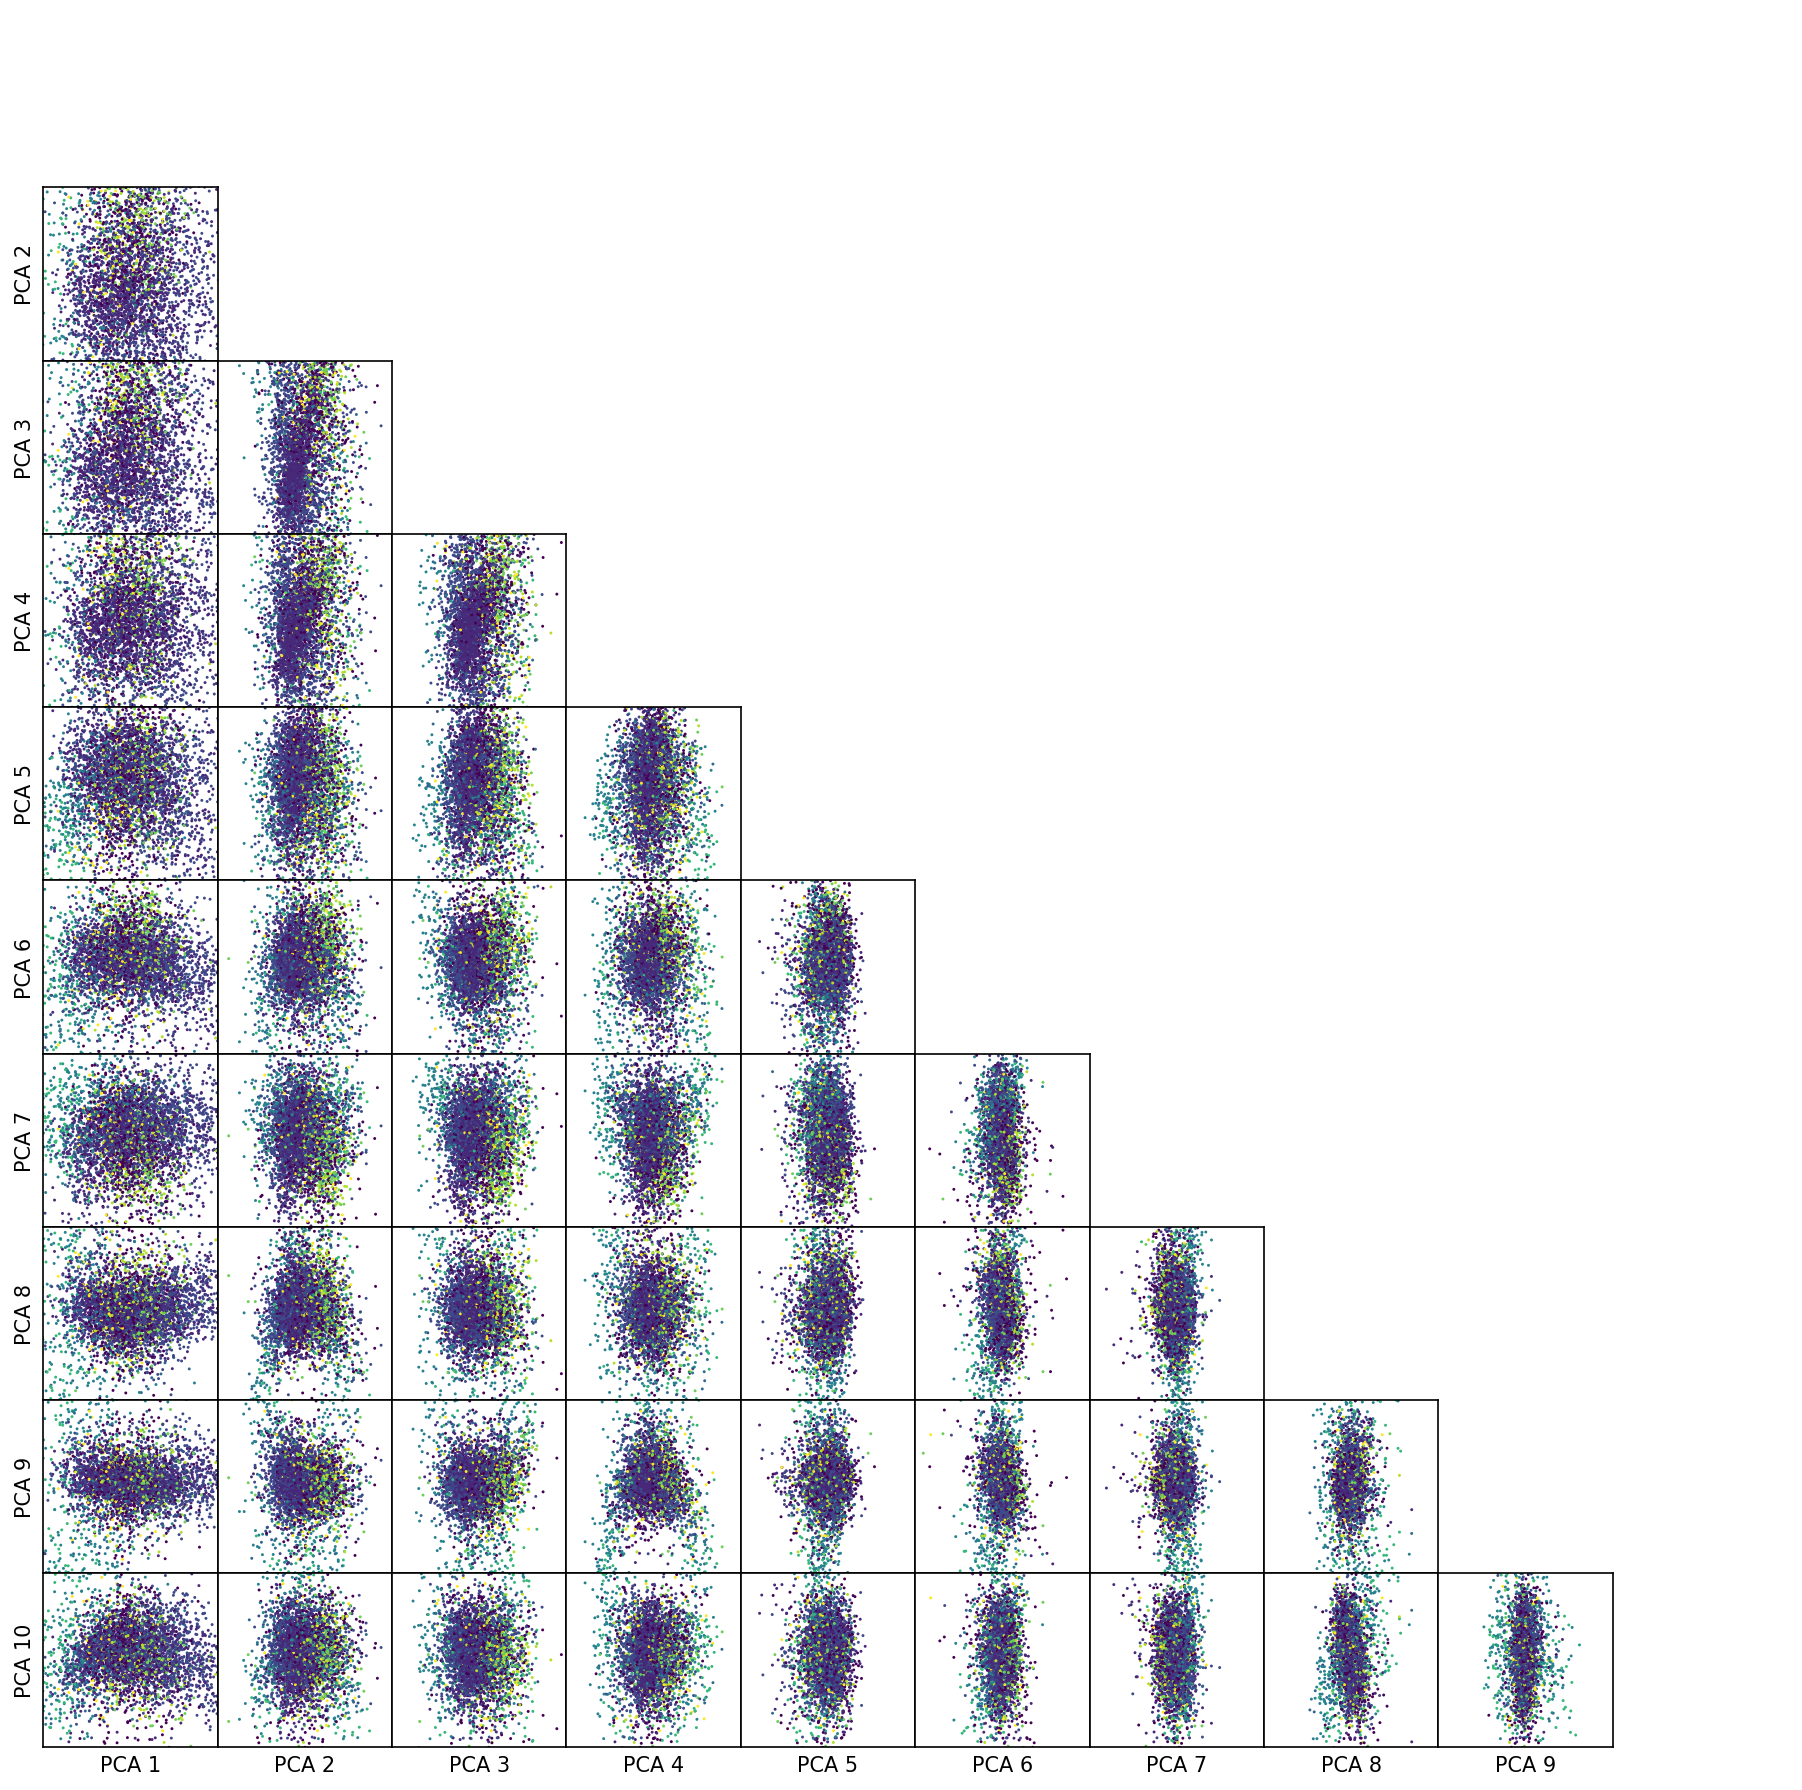

In [47]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15), sharex=True, sharey=True, dpi=150)

for i, ax_col in enumerate(axes):
    for j, ax in enumerate(ax_col):
        if j >= i:
            ax.axis('off')
            continue

        ax.scatter(mu_pca_list[:, j], mu_pca_list[:, i], c=y_list, s=2, edgecolor='none')

        if i == 9:
            ax.set_xlabel(f'PCA {j+1}')
            ax.set_ylim(*np.quantile(mu_pca_list[:, i], [0.01, 0.99]))
        if j == 0:
            ax.set_ylabel(f'PCA {i+1}')
            ax.set_xlim(*np.quantile(mu_pca_list[:, j], [0.01, 0.99]))
        ax.set_xticks([])
        ax.set_yticks([])

fig.subplots_adjust(wspace=0, hspace=0)

# Visual comparison

In [48]:
with torch.no_grad():
    model.eval()
    model_mmd.eval()

    x, y = next(iter(valid_loader))

x = x.to(device)
x_hat_elbo, *_ = model(x)
x_hat_mmd, *_ = model_mmd(x)

                         1 through 6
                           Original


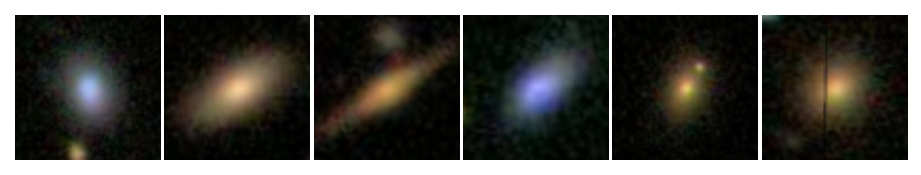

                             ELBO


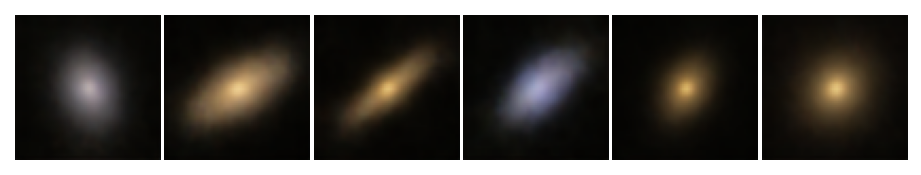

                             MMD


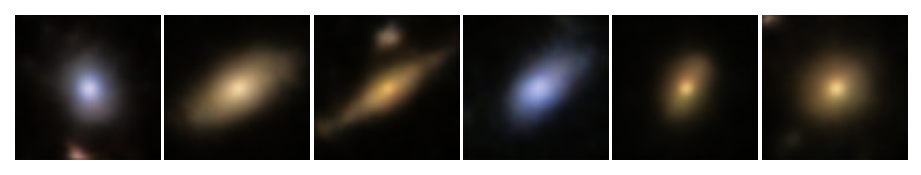

                         7 through 12
                           Original


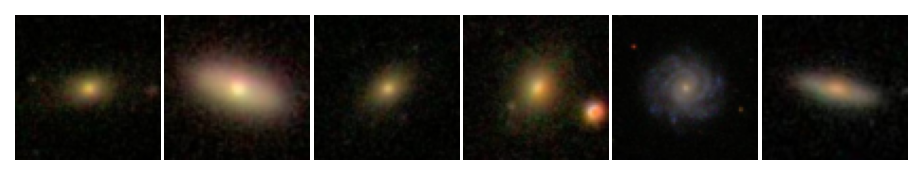

                             ELBO


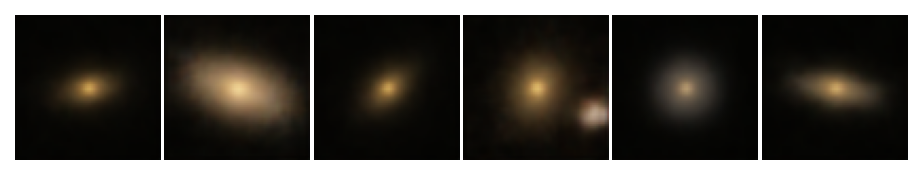

                             MMD


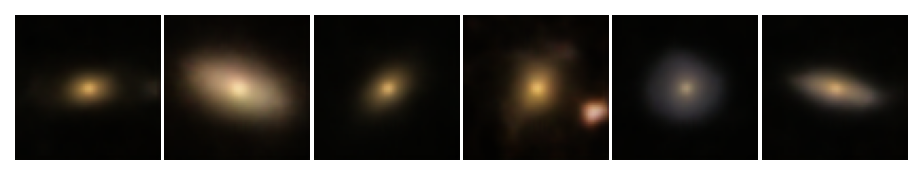

                         13 through 18
                           Original


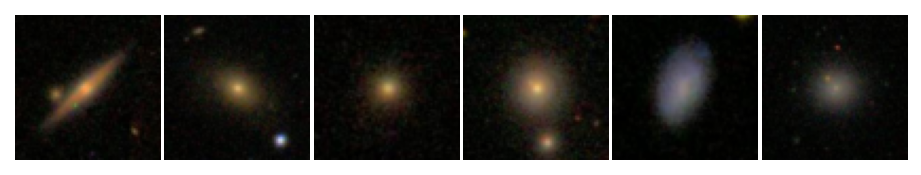

                             ELBO


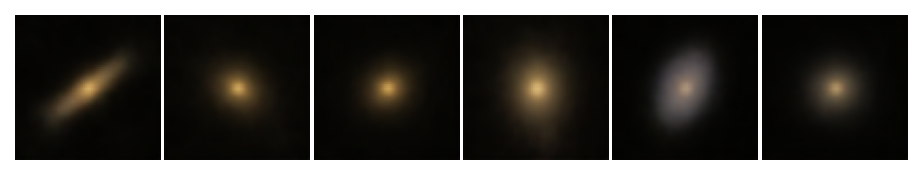

                             MMD


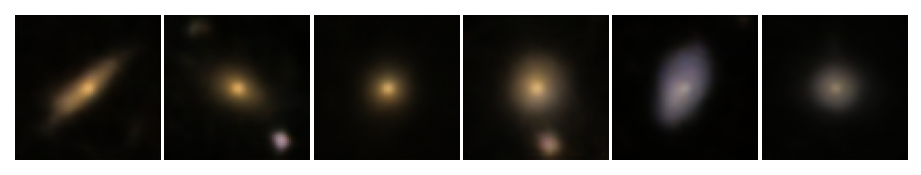

                         19 through 24
                           Original


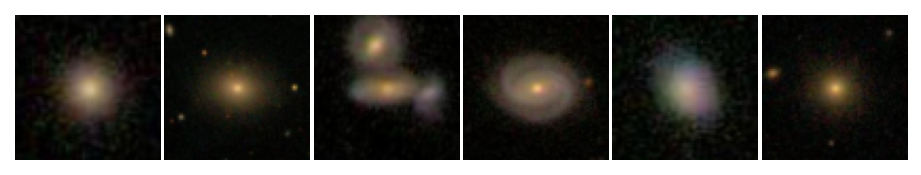

                             ELBO


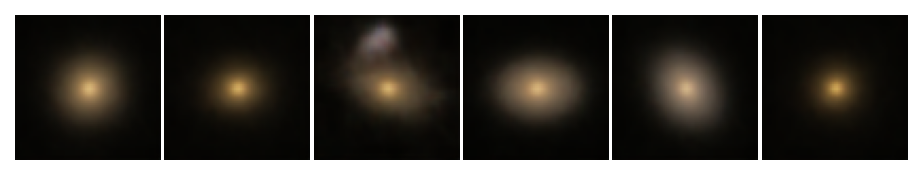

                             MMD


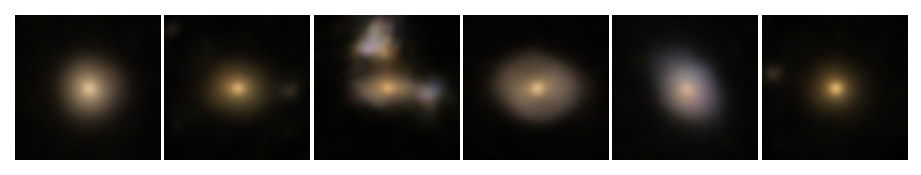

                         25 through 30
                           Original


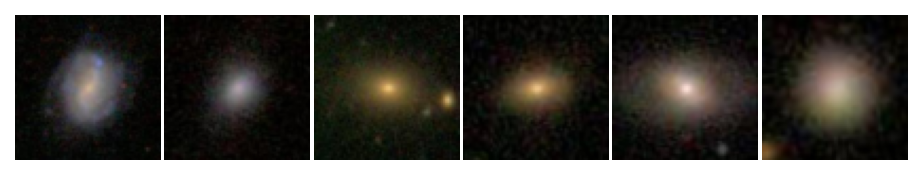

                             ELBO


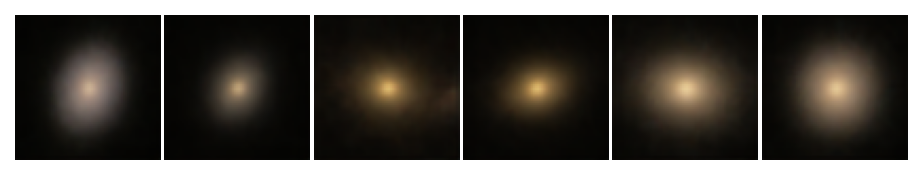

                             MMD


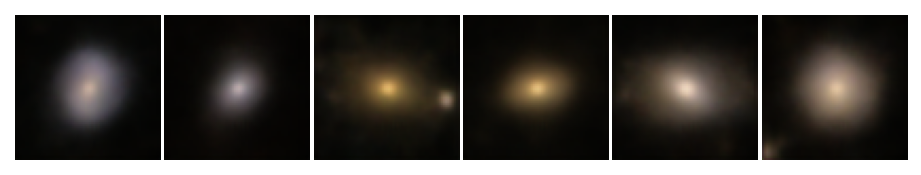

In [49]:
N = 6

for start in np.arange(0, 30, 6):

    print('==============================================================')
    print(f'                         {start+1} through {start+N}')
    print('==============================================================')
    print('                           Original')
    in_ = np.array(x.data.cpu() * 255, dtype=int).transpose((0, 2, 3, 1))
    plt.figure(figsize=(6, 2), dpi=150)
    for n in range(N):
        plt.subplot(1, N, n + 1)
        plt.imshow(in_[start + n])
        plt.axis('off')
    plt.tight_layout(pad=0.2)
    plt.show()

    print('                             ELBO')
    out_elbo = np.array(x_hat_elbo.data.cpu() * 255, dtype=int).transpose((0, 2, 3, 1))
    plt.figure(figsize=(6, 2), dpi=150)
    for n in range(N):
        plt.subplot(1, N, n + 1)
        plt.imshow(out_elbo[start + n])
        plt.axis('off')
    plt.tight_layout(pad=0.2)
    plt.show()

    print('                             MMD')
    out_mmd = np.array(x_hat_mmd.data.cpu() * 255, dtype=int).transpose((0, 2, 3, 1))
    plt.figure(figsize=(6, 2), dpi=150)
    for n in range(N):
        plt.subplot(1, N, n + 1)
        plt.imshow(out_mmd[start + n])
        plt.axis('off')
    plt.tight_layout(pad=0.2)
    plt.show()



# Generating samples with MMD VAE

## Varying along first dimension

In [50]:
# first latent variable
latent_mu_stats = np.array([np.quantile(mu_pca_list[:, i], [0.005, 0.025, 0.16, 0.5, 0.84, 0.975, 0.995]) for i in range(10)]).T
latent_mu_stats[:, 0]

array([-74.73509096, -57.72065254, -29.61732624,  -0.6941467 ,
        29.63138408,  62.24778655,  79.35875513])

In [51]:
def decode(vae_model, z):
    x_hat = vae_model.dec1(z)
    x_hat = F.interpolate(x_hat, size=(35, 35), mode='bilinear')

    x_hat = vae_model.dec2(x_hat)
    x_hat = F.interpolate(x_hat, size=(69, 69), mode='bilinear')

    return vae_model.dec3(x_hat)

In [52]:
latent_mu_stats[:, 0]

array([-74.73509096, -57.72065254, -29.61732624,  -0.6941467 ,
        29.63138408,  62.24778655,  79.35875513])

In [53]:
N_samples = 7

latent_vecs_pca = np.column_stack([latent_mu_stats[:, 0], np.zeros((N_samples, 9))])
latent_vecs = pca.inverse_transform(latent_vecs_pca)

latent_vecs = torch.FloatTensor(latent_vecs).to(device)

x_reconstructed = decode(model_mmd, latent_vecs)

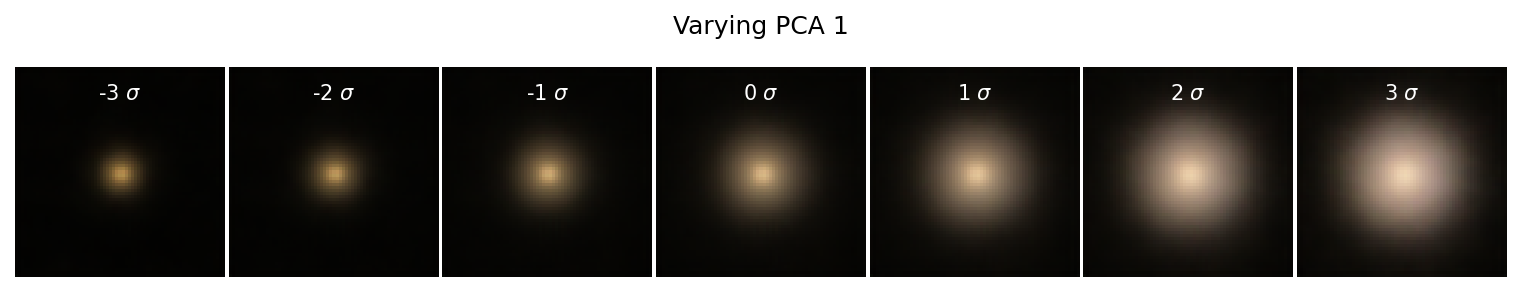

In [54]:
in_ = np.array(x_reconstructed.data.cpu() * 255, dtype=int).transpose((0, 2, 3, 1))

N = 7
plt.figure(figsize=(10, 2), dpi=150)
plt.suptitle('Varying PCA 1')
for n in range(N):
    plt.subplot(1, N, n + 1)
    plt.imshow(in_[n])
    plt.axis('off')
    plt.text(0.5, 0.85, str(n - 3) + r' $\sigma$', ha='center', transform=plt.gca().transAxes, color='white')
plt.tight_layout(pad=0.2)
plt.show()

## Varying along other dims

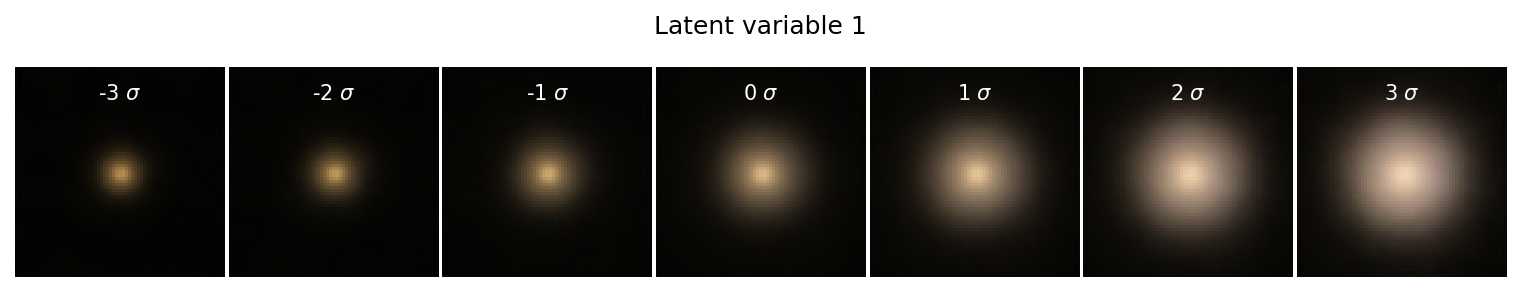

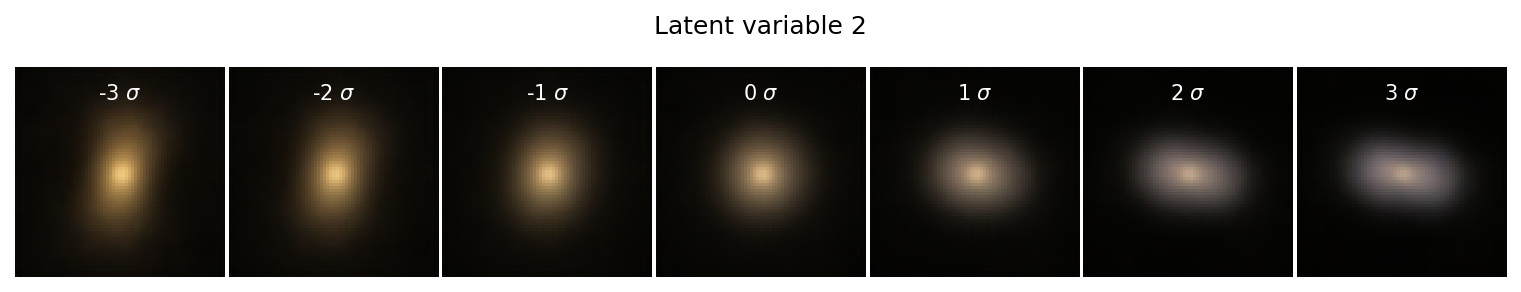

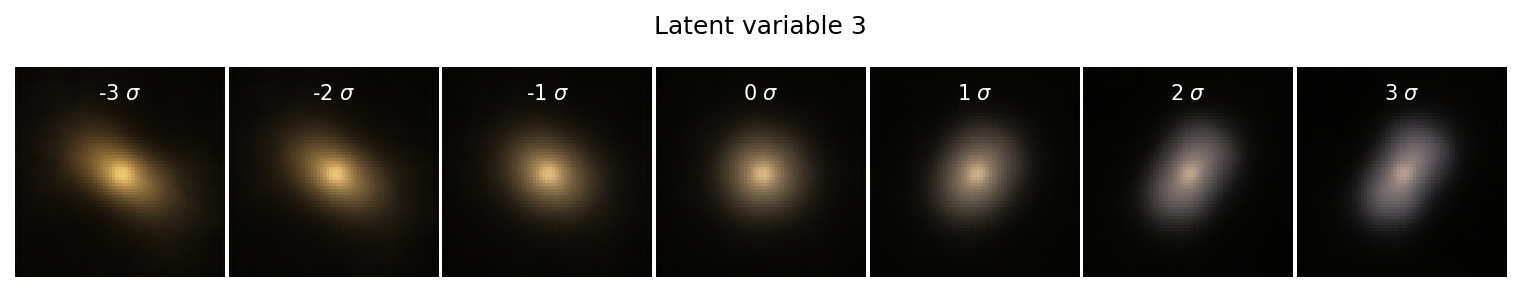

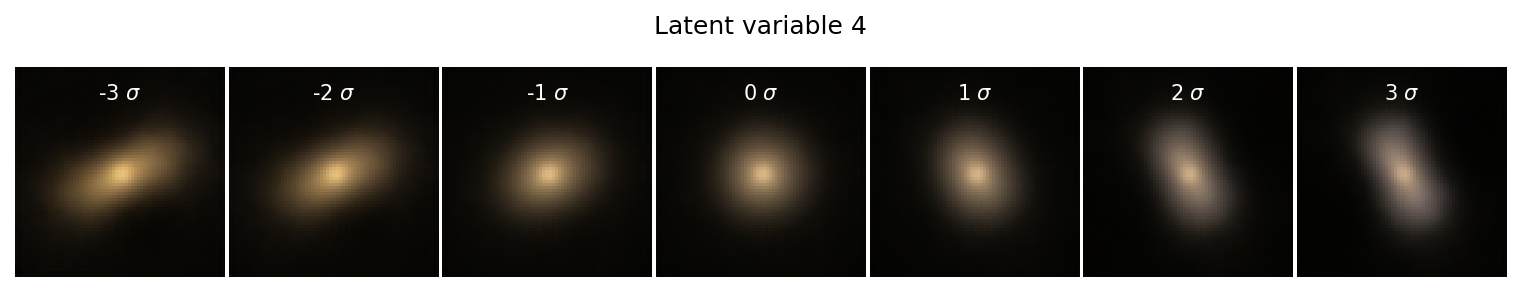

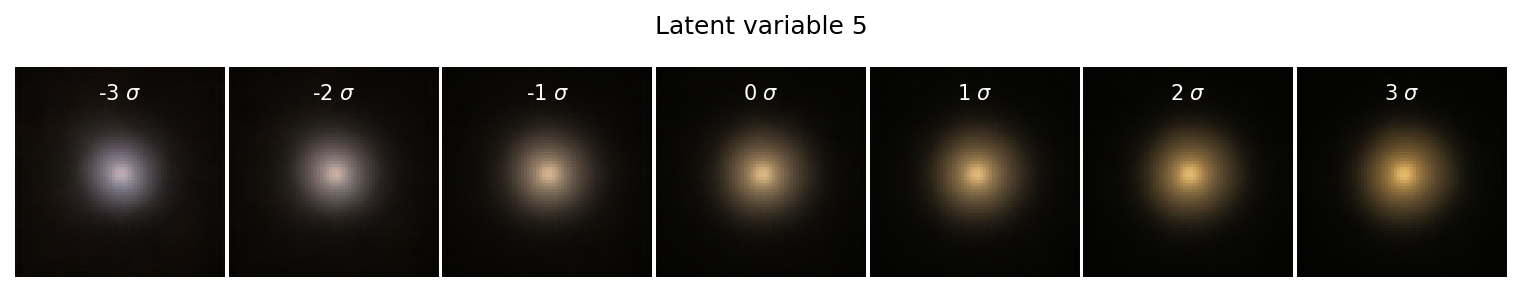

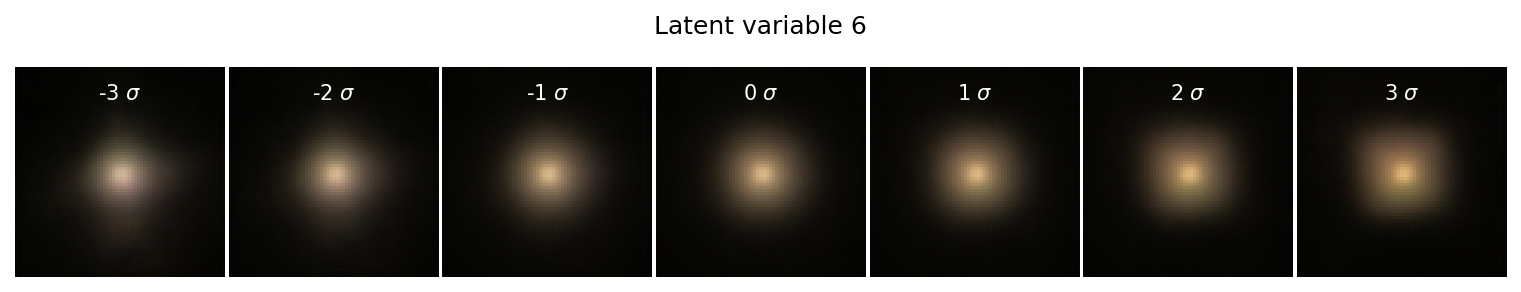

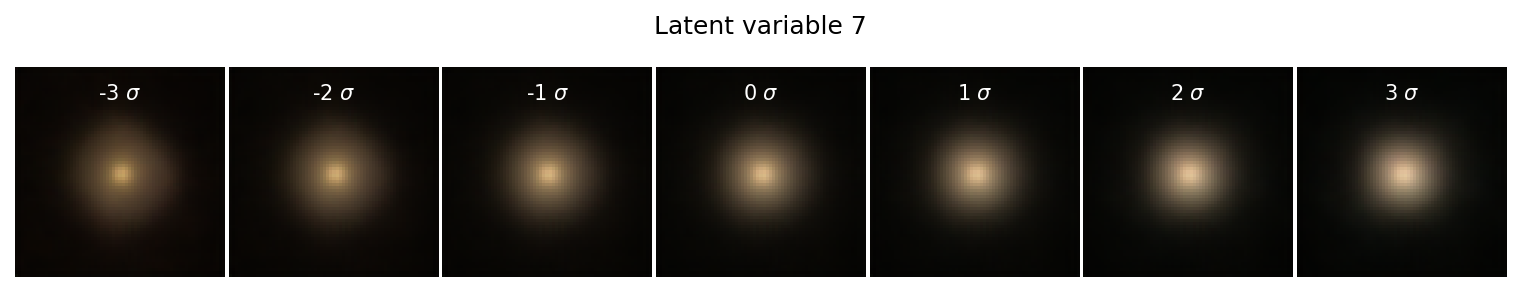

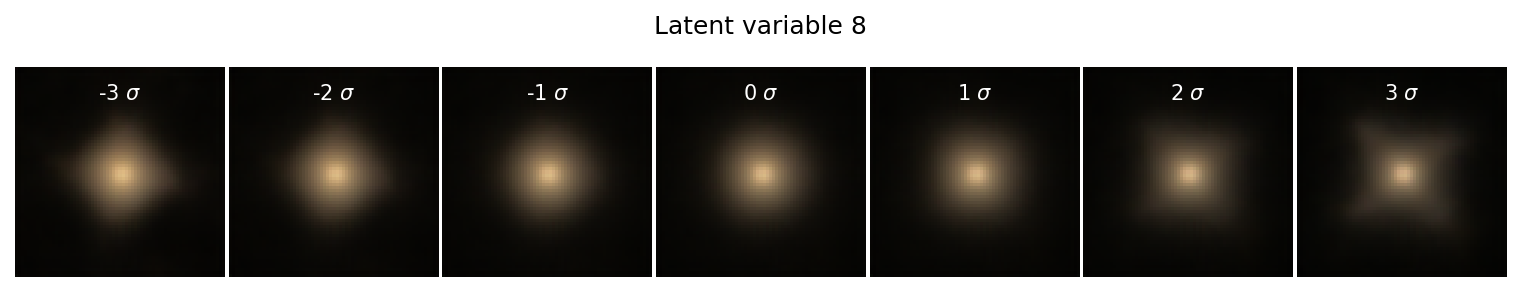

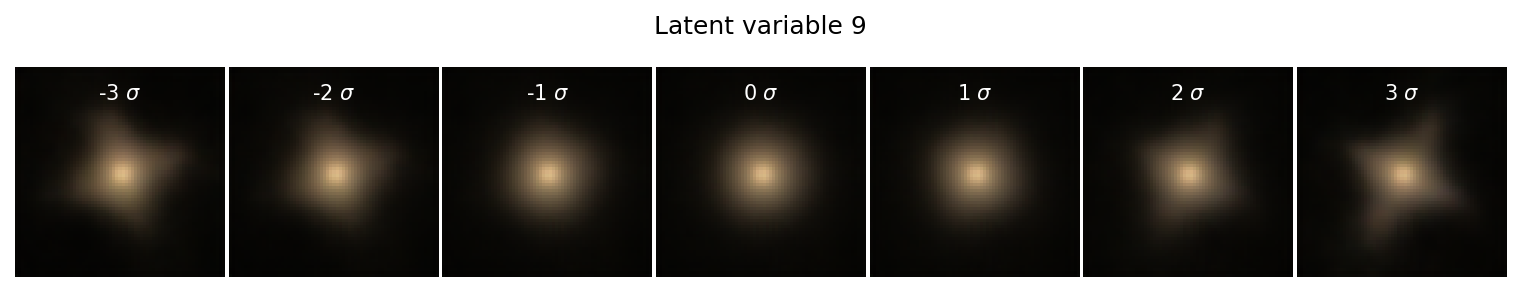

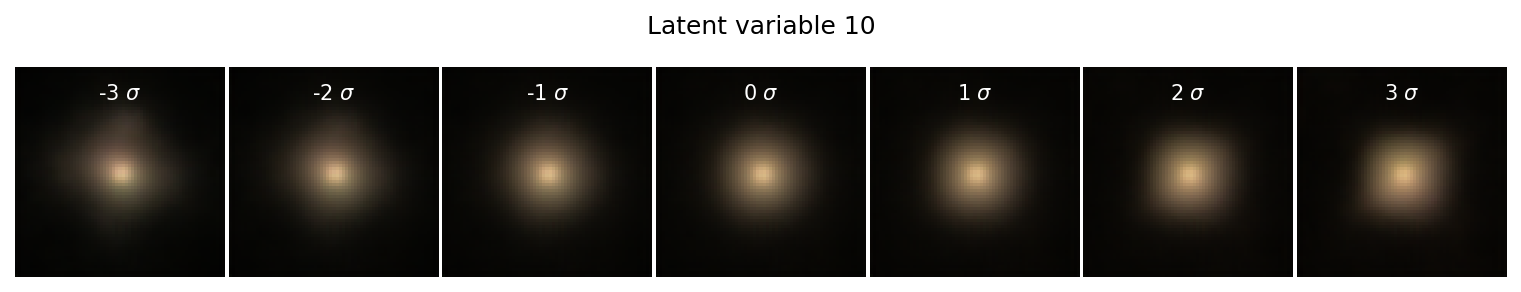

In [55]:
N_samples = 7


for d in range(0, 10):
    latent_vecs_pca = np.zeros((N_samples, 10))
    latent_vecs_pca[:, d] = latent_mu_stats[:, d]
    latent_vecs = pca.inverse_transform(latent_vecs_pca)

    latent_vecs = torch.FloatTensor(latent_vecs).to(device)

    x_reconstructed = decode(model_mmd, latent_vecs)

    in_ = np.array(x_reconstructed.data.cpu() * 255, dtype=int).transpose((0, 2, 3, 1))

    N = 7
    plt.figure(figsize=(10, 2), dpi=150)
    plt.suptitle(f'Latent variable {d+1}')
    for n in range(N):
        plt.subplot(1, N, n + 1)
        plt.imshow(in_[n])
        plt.axis('off')
        plt.text(0.5, 0.85, str(n - 3) + r' $\sigma$', ha='center', transform=plt.gca().transAxes, color='white')
    plt.tight_layout(pad=0.2)
    plt.show()